In [1]:
import pyodbc
import numpy as np
import pandas as pd
import warnings
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [11]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 100)

In [2]:
def openConnection():
    connectionString = '''
                       Driver={SQL Server};
                       Server=LCB-SQL.uccob.uc.edu\\nicholdw;
                       Database=GroceryStoreSimulator;
                       uid=IS7036Spring2023Login;
                       pwd=DogMouseFish42@@;');
                       MARS_Connection=Yes
                       '''
    print("Connection String:", connectionString)
    database_conn = pyodbc.connect(connectionString)   
    return database_conn

In [3]:
pyodbc.drivers()

['SQL Server', 'ODBC Driver 17 for SQL Server']

In [7]:
conn = openConnection()

Connection String: 
                       Driver={SQL Server};
                       Server=LCB-SQL.uccob.uc.edu\nicholdw;
                       Database=GroceryStoreSimulator;
                       uid=IS7036Spring2023Login;
                       pwd=DogMouseFish42@@;');
                       MARS_Connection=Yes
                       


In [8]:
cursor = conn.cursor()

In [9]:
for row in cursor.tables(tableType='TABLE'):
    print(row.table_name)

sysdiagrams
tBrand
tConfig
tContainer
tCountry
tCoupon
tCouponDetail
tCouponSource
tDiscountType
tEmpl
tEmplHistory
tEmplStatus
tEmplTitle
tIngredient
tLog
tLoyalty
tLoyaltyStatus
tManufacturer
tMethodOfPayment
tMonth
tName
tNumber
tOrder
tOrderDetail
tOrderStatus
tProduct
tProductIngredient
tProductPriceHist
tServing_size_UOM
tState
tStore
tStore_StoreComponent
tStoreComponent
tStoreHistory
tStoreStatus
tSupplyChain
tTransaction
tTransactionDetail
tTransactionType
tUOM
trace_xe_action_map
trace_xe_event_map


In [12]:
Transaction = pd.read_sql(
    "SELECT TransactionID, DateOfTransaction, StoreID, LoyaltyID, TransactionTypeID, EmplID, Comment, DateEntered, OrderID FROM tTransaction;", 
    conn)

In [13]:
TransactionDetail = pd.read_sql(
    "SELECT * FROM tTransactionDetail;", 
    conn)

In [14]:
Product = pd.read_sql(
    "SELECT * FROM tProduct;", 
    conn)

In [15]:
Brand = pd.read_sql(
    "SELECT * FROM tBrand;", 
    conn)

# Unsupervised Learning

## Customer Segmentation

Customer segmentation is the process of dividing customers into groups based on shared characteristics or behaviors. This is useful for businesses to better understand their customers and to tailor their marketing and sales efforts to specific customer groups.

Clustering analysis is a statistical technique that groups data points based on their similarities or dissimilarities. In the context of customer segmentation, clustering analysis can group customers based on various factors, such as demographics, purchase behavior, interests, and more. In the Grocery Store Simulator dataset, we create clusters based on QtyOfProduct, PricePerSellableUnitToTheCustomer and devise different categories of transactions.

In [16]:
df = pd.merge(pd.merge(Brand, Product, on='BrandID', how='inner'), TransactionDetail, on='ProductID', how='inner')

In [17]:
df2 = TransactionDetail.groupby(by = 'TransactionID')

In [18]:
df2 = df2.sum()

In [19]:
df2.head()

,TransactionDetailID,ProductID,QtyOfProduct,PricePerSellableUnitAsMarked,TotalPrice,CouponDetailID,PricePerSellableUnitToTheCustomer
TransactionID,,,,,,,
1,36,1923,17,58.93,140.08,0.0,58.93
2,342,5404,121,92.01,749.38,0.0,92.01
3,1275,7154,257,234.11,2265.57,0.0,234.11
4,2002,6188,167,191.10,1464.59,0.0,191.10
5,2016,4339,100,156.26,721.33,0.0,156.26


In [55]:
df2.describe()

,TransactionDetailID,ProductID,QtyOfProduct,PricePerSellableUnitAsMarked,TotalPrice,CouponDetailID,PricePerSellableUnitToTheCustomer
count,3.524330e+05,352433.000000,352433.000000,352433.000000,352433.000000,352433.000000,352433.000000
mean,4.750921e+07,4083.501012,149.645771,360.546103,3565.459968,585.295069,359.762767
std,5.215561e+07,3387.573098,164.831521,598.740950,7894.158654,1032.356258,599.056324
min,3.600000e+01,2.000000,1.000000,0.240000,0.000000,0.000000,0.000000
25%,1.085388e+07,1134.000000,33.000000,39.600000,0.000000,0.000000,38.350000
50%,2.798655e+07,3573.000000,104.000000,124.930000,0.000000,0.000000,123.760000
75%,6.772515e+07,6048.000000,196.000000,217.510000,591.190000,946.000000,216.340000
max,5.811628e+08,29451.000000,4242.000000,3116.510000,43954.480000,12418.000000,3116.510000


In [20]:
X = np.array(df2[['QtyOfProduct','PricePerSellableUnitToTheCustomer']])

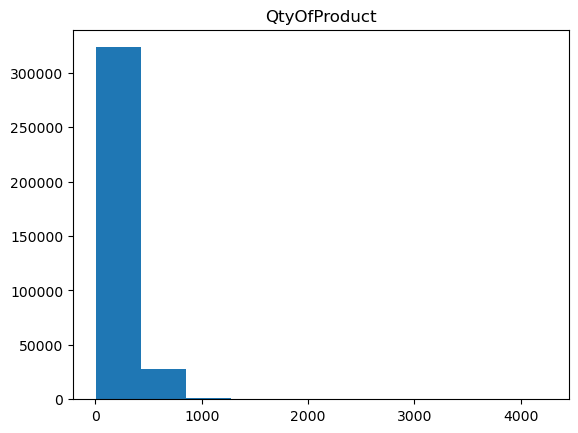

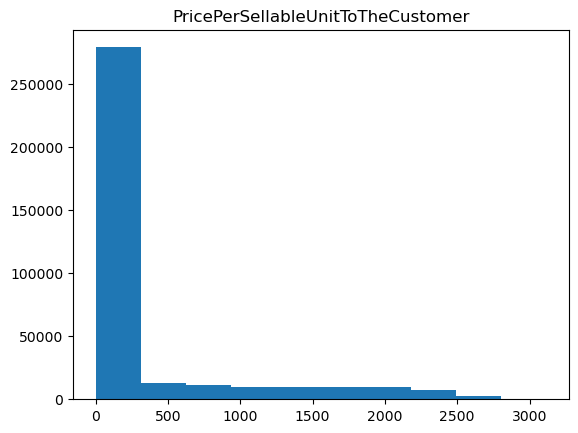

In [21]:
To_plot=df2[['QtyOfProduct','PricePerSellableUnitToTheCustomer']]

for i in To_plot:
    plt.figure()
    plt.title(label=i)
    plt.hist(df2[i])
    plt.show()

In [22]:
df3=df2[['QtyOfProduct','PricePerSellableUnitToTheCustomer']].clip(lower = df2.quantile(0.01), upper = df2.quantile(0.99), axis = 1)
df3

,QtyOfProduct,PricePerSellableUnitToTheCustomer
TransactionID,,
1,17,58.93
2,121,92.01
3,257,234.11
4,167,191.10
5,100,156.26
...,...,...
354405,4,17.98
354406,124,117.80
354407,105,69.43


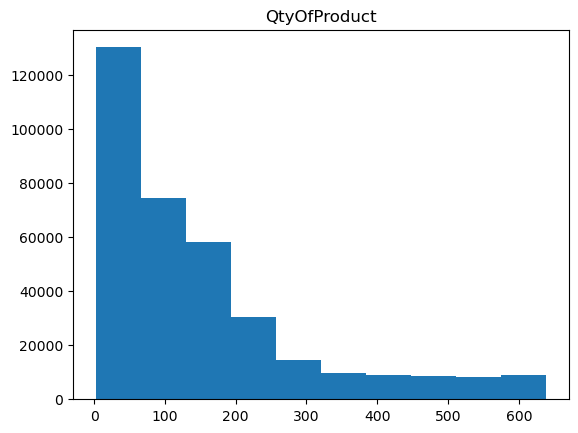

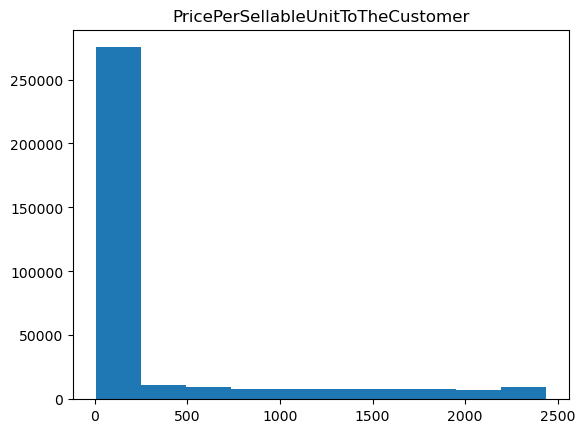

In [23]:
To_plot=df3[['QtyOfProduct','PricePerSellableUnitToTheCustomer']]

for i in To_plot:
    plt.figure()
    plt.title(label=i)
    plt.hist(df3[i])
    plt.show()

In [24]:
X = np.array(df3[['QtyOfProduct','PricePerSellableUnitToTheCustomer']])

In [25]:
x_train, x_test = train_test_split(X, test_size = 0.2)

In [27]:
range_n_clusters = [3, 4, 5, 6]

for i in range_n_clusters:
    clusterer = KMeans(n_clusters = i, random_state=0)
    cluster_labels = clusterer.fit_predict(x_test)
    silhouette_avg = silhouette_score(x_test, cluster_labels)
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.7837154651634778
For n_clusters = 4 The average silhouette_score is : 0.7416698973333047
For n_clusters = 5 The average silhouette_score is : 0.5420089163745605
For n_clusters = 6 The average silhouette_score is : 0.5446089223872834


In [28]:
kmeans = sklearn.cluster.KMeans(n_clusters = 3, random_state = 0)

In [31]:
label = kmeans.fit_predict(x_test)
print(label)

[0 0 0 ... 0 0 0]


In [32]:
filtered_label0 = x_test[label == 0]
filtered_label1 = x_test[label == 1]
filtered_label2 = x_test[label == 2]

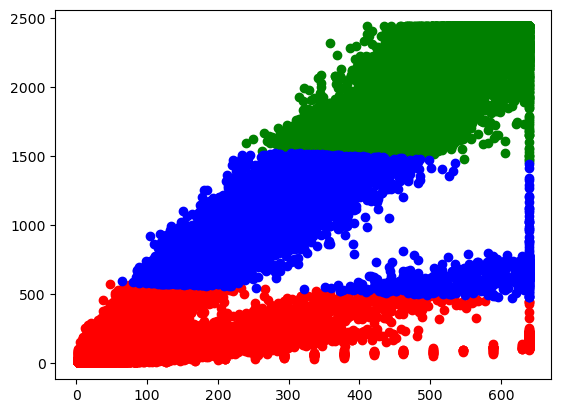

In [33]:
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], color='r')
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1], color='g')
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1], color='b')

## Type of transactions

1. High Spend High Qty - Green - Price and quantity are well above average > Implies wholesale customers
2. High Spend Medium to High Qty - Blue > Implies mid-scale retailers
4. Low - Medium Spend Full scale Qty - Red >> Implies small scale retailers

Qty Mean: 147.33
Price Mean: 358.41

# Supervised Learning
## Product Price Prediction

This supervised learning model is a regression model that aims to predict the price of a product based on its nutritional and calorific value. The model uses a supervised learning approach, which means that it learns from a labeled dataset where the input features (nutritional and calorific values) are associated with the corresponding output labels (product prices). Important independent variables are chosen based on market research and data quality.

In [34]:
Product.describe()

,ProductID,ManufacturerID,BrandID,InitialPricePerSellableUnit,NameID,ContainerID,Size,Size_UOMID,I_Size,I_UOMID,Serving_Size,Serving_Size_UOMID,I_Serving_Size,I-Serving_Size_UOMID,Servings_Per_Container,Calories,Total_Fat_G,Dvp_Total_Fat,Sodium_MG,Dvp_Sodium,Carbohydrates_G,Dvp_Carbohydrates,Sugars_G,Protein_G,Net_Carbs_G,Dvp_Calcium,Dvp_Vitamin_D,Dvp_Folic_Acid,Dvp_Phosphorus,Dvp_Iodine,Caffeine_Mg
count,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,489.000000,487.000000,498.000000,2.000000,482.000000,451.000000,490.000000,491.000000,488.000000,490.000000,488.000000,486.000000,487.000000,487.000000,488.000000,487.000000,460.000000,486.000000,1.0,345.000000,42.000000,22.000000,72.000000,2.000000,10.000000
mean,253.014000,37.05600,94.228000,7.325020,38.692000,12.484000,23.320204,3.135524,284.903855,2.500000,4.592967,3.141907,130.019796,195.912424,12.150000,131.971429,4.156967,6.454733,251.548255,10.466119,19.430328,6.474333,10.604348,4.561728,12.0,5.855072,18.404762,38.045455,10.194444,42.500000,39.300000
std,145.180358,22.45398,52.663449,4.073307,25.030986,7.734947,53.994577,1.375158,252.840968,0.707107,3.913386,1.353939,115.992277,10.368834,63.917681,79.903695,4.869959,7.466973,274.750506,11.531598,14.195875,4.690291,12.397905,5.817083,NaN,7.951662,6.829132,28.249698,6.510314,3.535534,15.398773
min,2.000000,1.00000,1.000000,0.240000,1.000000,1.000000,0.110000,1.000000,0.500000,2.000000,0.310000,1.000000,0.500000,2.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,12.0,0.000000,8.000000,0.000000,2.000000,40.000000,23.000000
25%,127.750000,18.00000,53.000000,3.580000,11.000000,3.000000,4.750000,1.000000,51.000000,2.250000,1.100000,1.000000,30.000000,188.000000,1.000000,80.000000,0.000000,0.000000,40.000000,2.000000,7.000000,2.000000,0.000000,0.000000,12.0,0.000000,10.000000,11.250000,4.000000,41.250000,34.000000
50%,252.500000,33.50000,94.000000,7.310000,43.000000,17.000000,12.000000,4.000000,252.500000,2.500000,2.500000,4.000000,64.000000,200.000000,3.750000,130.000000,2.500000,4.000000,150.000000,6.000000,18.000000,6.000000,5.000000,2.500000,12.0,4.000000,20.000000,34.000000,8.000000,42.500000,35.500000
75%,379.250000,54.00000,135.000000,10.497500,62.000000,18.000000,20.000000,4.000000,471.675000,2.750000,8.000000,4.000000,240.000000,200.000000,8.625000,180.000000,7.000000,11.000000,390.000000,16.000000,28.000000,9.000000,20.000000,6.000000,12.0,8.000000,25.000000,50.000000,15.000000,43.750000,37.500000
max,504.000000,86.00000,238.000000,15.330000,78.000000,30.000000,672.000000,6.000000,1244.000000,3.000000,23.700000,4.000000,700.000000,200.000000,1136.000000,430.000000,30.000000,46.000000,1390.000000,58.000000,75.000000,25.000000,48.000000,32.000000,12.0,35.000000,30.000000,100.000000,30.000000,45.000000,80.000000


In [35]:
Product.isnull().sum()

ProductID                             0
Status                                2
UPC-E                                 2
UPC-A                                 0
ManufacturerID                        0
BrandID                               0
InitialPricePerSellableUnit           0
NameID                                0
Description                           0
ContainerID                           0
Size                                 11
Size_UOMID                           13
I_Size                                2
I_UOMID                             498
Parent                                2
Count                                 2
Endorsement(s)                        2
Country                               1
Prepared / Notes - Health Claims      2
Serving_Size                         18
Serving_Size_UOMID                   49
I_Serving_Size                       10
I-Serving_Size_UOM                    1
I-Serving_Size_UOMID                  9
Pieces                                2


In [36]:
Product_valid = Product.loc[:, ['Size', 'Serving_Size', 'Calories', 'Sodium_MG', 'Total_Fat_G', 'Carbohydrates_G', 'Protein_G', 'InitialPricePerSellableUnit']]

In [37]:
Product_valid

,Size,Serving_Size,Calories,Sodium_MG,Total_Fat_G,Carbohydrates_G,Protein_G,InitialPricePerSellableUnit
0,12.00,1.00,150.0,NaN,NaN,NaN,NaN,2.31
1,20.00,8.00,0.0,65.0,0.0,0.0,0.0,9.26
2,20.00,8.00,0.0,65.0,0.0,0.0,0.0,4.72
3,14.00,8.00,120.0,40.0,0.0,32.0,0.0,1.24
4,2.10,8.00,0.0,25.0,0.0,0.0,0.0,14.40
...,...,...,...,...,...,...,...,...
495,15.00,3.00,45.0,340.0,0.0,8.0,3.0,4.14
496,67.50,6.75,60.0,55.0,0.0,16.0,0.0,1.35
497,67.50,6.75,60.0,55.0,0.0,16.0,0.0,2.32
498,0.17,1.00,310.0,NaN,0.1,62.0,1.0,3.45


In [38]:
Product_valid = Product_valid.fillna(0)

In [39]:
x = Product_valid.iloc[:,:-1]
y = Product_valid.InitialPricePerSellableUnit

In [40]:
x.shape

(500, 7)

In [41]:
y.shape

(500,)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [43]:
feature_label = x.columns

In [44]:
feature_label

Index(['Size', 'Serving_Size', 'Calories', 'Sodium_MG', 'Total_Fat_G',
       'Carbohydrates_G', 'Protein_G'],
      dtype='object')

In [45]:
forest = RandomForestRegressor(n_estimators = 100, random_state = 0, n_jobs = -1)
forest.fit(x_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [46]:
feature_imp = forest.feature_importances_

In [47]:
feature_scores = pd.Series(feature_imp, index=x_train.columns).sort_values(ascending=False)
feature_scores

Size               0.222771
Sodium_MG          0.215453
Carbohydrates_G    0.183706
Calories           0.143853
Protein_G          0.081597
Total_Fat_G        0.077750
Serving_Size       0.074869
dtype: float64

In [48]:
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(x_train)
x_test_scaled = std_scaler.fit_transform(x_test)

In [49]:
forest = RandomForestRegressor(random_state = 0)
forest.fit(x_train,y_train)

RandomForestRegressor(random_state=0)

In [51]:
y_pred = forest.predict(x_train)

In [52]:
MSE = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
MAE = mean_absolute_error(y_train, y_pred)

In [56]:
RandomForestResults = pd.DataFrame([['Random Forest Score', r2]],
                           columns = ['Model','R2'])
RandomForestResults

,Model,R2
0,Random Forest Score,0.781383
